##### <span style='color:Blue'> **III. Churn Prediction Models** </span>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

customer= pd.read_pickle('modifiedCus.pkl')
var_cate = [col for col in customer.columns if customer[col].dtype == 'object' and col != 'Churn']
var_nume = [col for col in customer.select_dtypes(include=['int64', 'float64']).columns if col != 'Churn']

print(var_cate)
print('------------')
print(var_nume)

['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender', 'PreferedOrderCat', 'MaritalStatus', 'Complain']
------------
['CityTier', 'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 'CashbackAmount', 'Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder']


In [2]:
sns.set_style('darkgrid')
np.set_printoptions(precision=2)
import warnings
warnings.filterwarnings("ignore")

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

The selected algorithms include Logistic Regression, Linear Discriminant Analysis, K-Nearest Neighbors, Decision Tree Classifier, Gaussian Naive Bayes, Random Forest Classifier, Support Vector Machine, Gradient Boosting Classifier, XGBoost Classifier, and AdaBoost Classifier.
By including a diverse set of algorithms, we aim to explore different modeling techniques and identify the most suitable one for the churn prediction task. It encodes the target variable using LabelEncoder, transforming categorical labels into numerical values required for model training.
- **Data Preprocessing**: By initializing a ColumnTransformer named preprocessor to apply preprocessing steps such as scaling for numeric variables and one-hot encoding for categorical variables, it ensures that the data is appropriately formatted and scaled before being fed into the models.

- **Model Training and Evaluation**: Each pipeline consists of preprocessing steps, oversampling using SMOTE (Synthetic Minority Over-sampling Technique), and the current classification model. It performs 10-fold cross-validation with stratified sampling using StratifiedKFold, ensuring that each fold maintains the same class distribution as the original dataset. Model performance is evaluated using ROC AUC scoring, which measures the ability of the model to distinguish between positive and negative classes. The results of each model evaluation are stored in the results list, and the corresponding model names are stored in the names list for later analysis.

In [3]:
seed= 961
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier(random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('RFC', RandomForestClassifier(random_state=seed)))
models.append(('SVM', SVC(random_state=seed)))
models.append(('GBC', GradientBoostingClassifier(random_state=seed)))
models.append(('XGB', XGBClassifier(random_state=seed, use_label_encoder=False, eval_metric='logloss')))
models.append(('ADA', AdaBoostClassifier(random_state=seed)))

In [4]:
results = []
names = []
xVar, yVar= customer.drop(['Churn'], axis=1), customer['Churn']
labelencoder= LabelEncoder()
yVar= labelencoder.fit_transform(yVar)
# ColumnTransformer to apply OneHot encoding to categorical variables and scaling to numeric variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), var_nume),
        ('cat', OneHotEncoder(), var_cate)
    ])

for name, model in models:
    # Creates a pipeline with SMOTE and the estimator
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=961)),
        (name, model)
    ])
    
    # 10-fold cross-validation with stratified sampling
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=961)
    result = cross_val_score(pipeline, xVar, yVar, cv=cv, scoring='roc_auc')
    
    results.append(result)
    names.append(name)

These mean accuracy scores indicate the average accuracy achieved by each model during cross-validation. Based on the output, it appears that the Random Forest Classifier (RFC) and XGBoost Classifier (XGB) achieved the highest mean accuracy scores, followed closely by K-Nearest Neighbors (KNN) and Support Vector Machine (SVM). Gaussian Naive Bayes (NB) achieved the lowest mean accuracy among the models.

In [5]:
# Average result of each model 
mean_results = [result.mean() for result in results]
model_mean_results = dict(zip(names, mean_results))

for model_name, mean_result in model_mean_results.items():
    print(f'{model_name}: Mean Accuracy = {mean_result:.4f}')

LR: Mean Accuracy = 0.8968
LDA: Mean Accuracy = 0.8963
KNN: Mean Accuracy = 0.9913
DTC: Mean Accuracy = 0.9340
NB: Mean Accuracy = 0.8136
RFC: Mean Accuracy = 0.9948
SVM: Mean Accuracy = 0.9706
GBC: Mean Accuracy = 0.9352
XGB: Mean Accuracy = 0.9954
ADA: Mean Accuracy = 0.9061


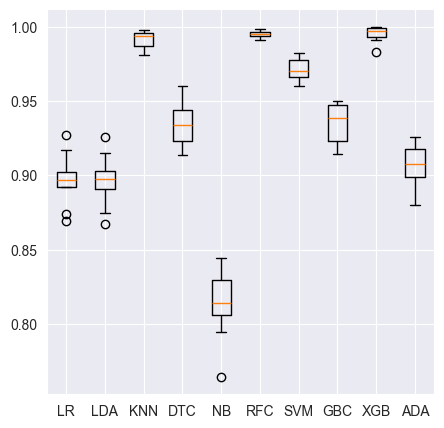

In [11]:
def boxplots_algorithms(results, names):
    
    plt.figure(figsize=(5,5))
    plt.boxplot(results)
    plt.xticks(range(1,len(names)+1), names)
    plt.show()
boxplots_algorithms(results, names)

<div class="alert alert-block alert-info">
<b>Best Performing Algorithm</b> Extreme Gradient Boosting with 99.54% Accuracy</div>



In [12]:
# Grid Search to find the best parameters
# Defines a range of values for different hyperparameters
param_grid = {
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__max_depth': [4, 5, 6],
    'xgb__subsample': [0.8, 0.9, 1.0],
    'xgb__colsample_bytree': [0.7, 0.8, 0.9],
    'xgb__n_estimators': [200, 300, 400],
    'xgb__objective': ['binary:logistic']
}

# Creates an XGBClassifier object
xgb = XGBClassifier(random_state=seed, use_label_encoder=False, eval_metric='logloss')

# Creates a pipeline with SMOTE
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=seed)),
    ('xgb', xgb)
])

# Creates GridSearchCV object with ROC-AUC as scoring metric
grid_search = GridSearchCV(
    estimator=pipeline, 
    param_grid=param_grid, 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=seed), 
    n_jobs=-1, 
    scoring='roc_auc', 
    verbose=1
)

# Fits the grid search to the data
grid_search.fit(xVar, yVar)

# Gets the best parameters and best score
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


In [13]:
print(f"Best Parameters: {best_parameters}")
print(f"Best Score: {best_score}")

Best Parameters: {'xgb__colsample_bytree': 0.7, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__n_estimators': 400, 'xgb__objective': 'binary:logistic', 'xgb__subsample': 0.9}
Best Score: 0.9928437789188786


In [14]:
X_train, X_test, y_train, y_test = train_test_split(xVar, yVar, test_size=0.2, random_state=seed)

# Creates a pipeline with preprocessing, SMOTE, and XGBoost classifier
final_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=seed)),
    ('xgb', XGBClassifier(
        colsample_bytree=0.7,
        learning_rate=0.1,
        max_depth=6,
        n_estimators=400,
        objective='binary:logistic',
        subsample=0.9,
        random_state=seed,
        use_label_encoder=False,
        eval_metric='logloss'))
])

# Fits the pipeline to the training data
final_pipeline.fit(X_train, y_train)

# Makes predictions on the training and test data
y_pred_train = final_pipeline.predict(X_train)
y_pred_test = final_pipeline.predict(X_test)

# Calculates accuracy on training and test sets
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

# Prints the accuracies
print(f"Training Set Accuracy: {accuracy_train:.4f}")
print(f"Test Set Accuracy: {accuracy_test:.4f}")

Training Set Accuracy: 1.0000
Test Set Accuracy: 0.9805


> **Final Model Performance**

- **Training Set Accuracy: 1.0; Testing set Accuracy: 98.05%.**

- **Specificity/Recall or True Negative (TN):** The model accurately identified 98.94% of cases as not churning, reflecting its strong ability to correctly predict customers who are not at risk of churning.

- **False Negative (FN):** Approximately 6.56% of cases were falsely predicted as not churning when they actually were, indicating instances where customers churned but the model failed to identify them as such.

- **Sensitivity or True Positive (TP):** The model successfully identified 93.44% of cases as churning, showcasing its effectiveness in predicting customers who will churn.

- **False Positive (FP):** Only 1.06% of cases were incorrectly predicted as churning when they were not, demonstrating the model's low rate of falsely flagging customers as at risk of churning.

> **Implications for the Company:**

- The high True Negative rate suggests that the model excels at recognizing customers who are not likely to churn, providing the company with valuable insights to focus resources on retaining other customer segments. While the True Positive rate is commendable at 87.69%, there remains room for improvement in accurately identifying customers who will churn. Enhancements in this area could lead to more targeted retention efforts and improved customer retention rates.

- The relatively high False Negative rate of 12.31% raises concerns, as these are instances where the model fails to predict customers who actually churn. Addressing this issue is crucial to prevent missed opportunities for intervention and mitigate potential revenue loss. The low False Positive rate is advantageous, as it indicates that the model rarely misidentifies customers as at risk of churning when they are not. However, the company should be mindful of the costs associated with unnecessary interventions on these customers.

Confusion Matrix:
 [[933  10]
 [ 12 171]]


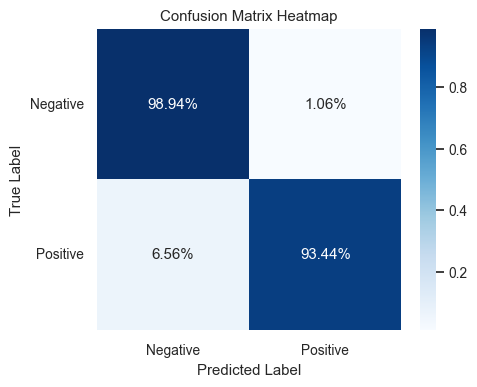

In [18]:
# Calculates the confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:\n", cm)

# Normalizes the confusion matrix to show percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
labels = ['Negative', 'Positive']
categories = ['Negative', 'Positive']

# Heat Map with ratios
plt.figure(figsize=(5, 4))
sns.set(font_scale=.9)
sns.heatmap(cm_normalized, annot=True, cmap='Blues', fmt='.2%', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.xticks(ticks=np.arange(0.5, 2.5), labels=categories, rotation=0)
plt.yticks(ticks=np.arange(0.5, 2.5), labels=categories, rotation=0)
plt.tight_layout()
plt.show()

##### <span style='color:Blue'> **IV. Conclusions** </span>

> **Summary of Findings**

The feature importance analysis conducted using the XGBoost algorithm reveals intriguing insights into the factors influencing churn prediction. Notably, the preferred order category emerges as the most crucial feature, boasting the highest relative importance within the model. This finding underscores the significant predictive power of this variable, indicating its pivotal role in the algorithm's decision-making process. Additionally, the city tier and gender variables exhibit notable relative importance, suggesting their substantial impact on churn prediction. While individual features may seem less influential when considered in isolation, their significance amplifies when combined with other features and the overall dataset structure. This underscores the importance of considering feature interactions and the holistic context of the data in predictive modeling.

It's important to clarify that the feature importance scores provided by XGBoost are relative rather than absolute. Although the preferred order category emerges as the most influential feature, this doesn't imply standalone predictive accuracy for churn. Moreover, the decline in importance beyond the top few features highlights the existence of a select set of key predictors that significantly outweigh others in their contribution to the model's predictive performance.

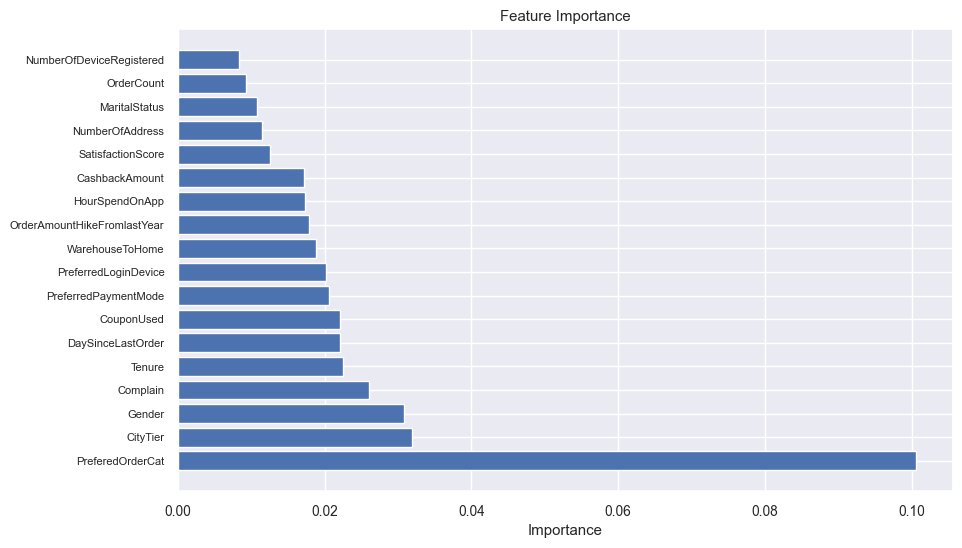

In [21]:
# Get the feature importances from the xgb step in the pipeline
importances = final_pipeline.named_steps['xgb'].feature_importances_
feature_importance_dict = dict(zip(xVar.columns, importances))

# Sorts features by importance (from highest to lowest)
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
sorted_feature_names, sorted_importances = zip(*sorted_features)

# Barplot
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
plt.yticks(range(len(sorted_importances)), sorted_feature_names, fontsize=8)
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

> **Actional For Future Marketing Approach**

- Identifying high-risk groups, such as single females residing in higher city tiers or customers utilizing multiple devices, enables the implementation of targeted interventions. By recognizing these specific demographics, tailored engagement strategies, loyalty programs, and personalized communication initiatives can be developed and deployed. This targeted approach is poised to yield more effective results, as it addresses the unique needs and preferences of these segments, ultimately enhancing customer satisfaction and retention.

- The analysis underscores the substantial impact of demographics, including gender, marital status, and city tier, alongside customer preferences such as login device and number of devices registered, on churn rates. Recognizing the influence of these factors presents an opportunity to customize marketing and customer service strategies accordingly. By tailoring approaches to align with specific demographic and preference-based segments, businesses can more effectively address the diverse needs and preferences of their customer base, thereby improving overall customer satisfaction and retention.

> Future Directions For Analysis

- **Feature Engineering:**
Invest more time in feature engineering to create new informative features or enhance existing ones. This could involve exploring interactions between variables, creating composite features, or incorporating domain knowledge to derive more relevant predictors.

- **Advanced Neural Network Architectures**: 
Experiment with more complex neural network architectures, such as deep neural networks (DNNs), convolutional neural networks (CNNs), or recurrent neural networks (RNNs), to capture intricate patterns in the data more effectively.


